In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import lux
import matplotlib.pyplot as plt
%matplotlib inline

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor': 'white',
                     'figure.edgecolor': 'white',
                     'axes.grid': True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
seed = 42
rng = np.random.default_rng(seed)

secure_bits = 1         # rows
corrected_key_bits = 50 # columns
N_vec = 10000           # nº of corrected key vectors

## Functions

### Detect power consumption of basic operations

In [3]:
def get_1times1_power(mat, vec, op_power):
    count = 0
    for i in range(secure_bits):
        for j in range(corrected_key_bits):
            if mat[i, j] and vec[j]:
                count += 1
    return count * op_power

In [4]:
def get_0times1_power(mat, vec, op_power):
    count = 0
    for i in range(secure_bits):
        for j in range(corrected_key_bits):
            if (not mat[i, j] and vec[j]) or \
               (mat[i, j] and not vec[j]):
                count += 1
    return count * op_power

In [5]:
def get_0times0_power(mat, vec, op_power):
    count = 0
    for i in range(secure_bits):
        for j in range(corrected_key_bits):
            if not mat[i, j] and not vec[j]:
                count += 1
    return count * op_power

In [6]:
# Some experiments...

# # Count all +1 (same as get_1times1_power...)
# def get_plus1_power(mat, vec, op_power):
#     count = 0
#     for i in range(secure_bits):
#         for j in range(corrected_key_bits):
#             if mat[i, j] * vec[j]:
#                 count += 1
#     return count * op_power

# Only count additions to initial 1 in each row (as if the first 1 was already in the memory address of the result)
def get_plus1_power(mat, vec, op_power):
    count = 0
    for i in range(secure_bits):
        count_1s = 0
        for j in range(corrected_key_bits):
            if mat[i, j] * vec[j]:
                count_1s += 1 # count 1s in each row
        if count_1s != 0:
            count += count_1s - 1 # sum 1+1 additions per row if there are any 1s
    return count * op_power

# Count 1+1 sequentially in each row (works even if operations are not sequential)
    # (counting 1+0 or 0+0 gives different results if operations are not sequential,
    # but counting (1+0)+(0+0) still gives consistent results)
def get_1plus1_power(mat, vec, op_power):
    count = 0
    for i in range(secure_bits):
        result = mat[i, 0] * vec[0]
        for j in range(1, corrected_key_bits):
            next_element = mat[i, j] * vec[j]
            if result and next_element:
                count += 1
            result = (result + next_element) % 2
    return count * op_power

### Class

In [7]:
# Detect if there are more 1s than 0s
def More_1_than_0(mat, vec):
    return np.sum(mat @ vec % 2) > secure_bits / 2

### Other

In [8]:
# Check if output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique = np.unique(res, axis=0, return_counts=True)
    return unique[1].shape[0] == np.shape(vec)[0], unique[1].shape[0]

## Generate data

In [9]:
mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)

mat.shape, mat

((1, 50),
 array([[1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
         1, 0, 1, 1, 0, 0]], dtype=int8))

In [10]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((10000, 50),
 array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0], dtype=int8))

In [30]:
print('Are solutions from this sample unique? %s ---> %i unique sols out of %i' % (*Check_uniqueness(mat, vec), N_vec))

Are solutions from this sample unique? False ---> 2 unique sols out of 10000


Assumptions on power consumption (totally random...):
- Read 0: &nbsp;0.15 
- Read 1: &nbsp;0.3
- Sum: &nbsp;&nbsp;&nbsp;&nbsp; 1
- Product: 4

Thus:

In [11]:
# Define power consumption for each operation
power_0times0 = 4.3
power_0times1 = 4.45
power_1times1 = 4.6
power_1plus1  = 1.6

In [32]:
print("1*1 \t 0*1 \t 0*0 \t +1 \t 1+1")
print("------------------------------------")
for i in range(10):
    print(f'{get_1times1_power(mat, vec[i], power_1times1):.1f} \t{get_0times1_power(mat, vec[i], power_0times1):.1f} \t'
          f'{get_0times0_power(mat, vec[i], power_0times0):.1f} \t{get_plus1_power(mat, vec[i], power_1plus1):.1f} \t'
          f'{get_1plus1_power(mat, vec[i], power_1plus1):.1f}')

1*1 	 0*1 	 0*0 	 +1 	 1+1
------------------------------------
73.6 	89.0 	60.2 	24.0 	12.8
69.0 	106.8 	47.3 	22.4 	11.2
69.0 	106.8 	47.3 	22.4 	11.2
50.6 	133.5 	38.7 	16.0 	8.0
50.6 	124.6 	47.3 	16.0 	8.0
82.8 	75.7 	64.5 	27.2 	14.4
46.0 	129.1 	47.3 	14.4 	8.0
87.4 	93.5 	43.0 	28.8 	14.4
82.8 	102.4 	38.7 	27.2 	14.4
55.2 	120.2 	47.3 	17.6 	9.6


In [33]:
print("#1 > #0?")
print("--------")
for i in range(10):
    print(More_1_than_0(mat, vec[i]), '\t', mat @ vec[i] % 2)

#1 > #0?
--------
False 	 [0]
True 	 [1]
True 	 [1]
True 	 [1]
True 	 [1]
False 	 [0]
False 	 [0]
True 	 [1]
False 	 [0]
False 	 [0]


In [12]:
data = [[round(get_1times1_power(mat, vec[i], power_1times1) + \
               get_0times1_power(mat, vec[i], power_0times1) + \
               get_0times0_power(mat, vec[i], power_0times0) + \
               # get_plus1_power(mat, vec[i], power_1plus1) + \
               get_1plus1_power(mat, vec[i], power_1plus1), 2),
         More_1_than_0(mat, vec[i])] for i in range(N_vec)]
np.shape(data)

(10000, 2)

In [13]:
# Create dataframe
df = pd.DataFrame(data, columns=['Power_trace', 'More_1_than_0'])
df

C:\Users\V082335\Anaconda3\envs\thesis\lib\site-packages\IPython\core\formatters.py:918: UserWarning:
Unexpected error in rendering Lux widget and recommendations. Falling back to Pandas display.
Please report the following issue on Github: https://github.com/lux-org/lux/issues 

C:\Users\V082335\Anaconda3\envs\thesis\lib\site-packages\lux\core\frame.py:628: UserWarning:Traceback (most recent call last):
  File "C:\Users\V082335\Anaconda3\envs\thesis\lib\site-packages\lux\core\frame.py", line 590, in _ipython_display_
    self.maintain_recs()
  File "C:\Users\V082335\Anaconda3\envs\thesis\lib\site-packages\lux\core\frame.py", line 445, in maintain_recs
    rec_df.show_all_column_vis()
  File "C:\Users\V082335\Anaconda3\envs\thesis\lib\site-packages\lux\core\frame.py", line 359, in show_all_column_vis
    vis = Vis(list(self.columns), self)
  File "C:\Users\V082335\Anaconda3\envs\thesis\lib\site-packages\lux\vis\Vis.py", line 40, in __init__
    self.refresh_source(self._source)
  File 

,Power_trace,More_1_than_0
0,235.60,False
1,234.30,True
2,234.30,True
3,230.80,True
4,230.50,True
...,...,...
9995,234.45,False
9996,234.75,True
9997,233.10,False
9998,234.15,False


In [36]:
# Check some trends in data (turn off numba engine first)
pd.set_option('compute.use_numba', False)
df2 = df.copy()
df2.intent = ['More_1_than_0']
display(df2)
pd.set_option('compute.use_numba', True)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
# Generate pandas profiling report
profile = ProfileReport(df, title="More_1s_or_0s Total_Power Dataset Report", explorative=True)
# profile.to_widgets()
profile.to_file("Docs/More_1s_or_0s_-_Total_Power_report.html")

### Split data

In [14]:
# Split data into training & test set
X = np.asarray(df.drop('More_1_than_0', axis=1))
y = np.asarray(df['More_1_than_0'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # used before cross-val

## Classifiers

Models able to to predict with good accuracy:
- Nope...

Models which comparatively suck:
- Logistic regression
- All SVM
- All Naïve Bayes
- Decision tree

In [15]:
# Train model with stratified k-fold cross-validation & get statistics
def Train_stratCV(model, X, y, n_splits=5, seed=seed):
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    lst_acc = []
    lst_y_pred = [] # not used yet

    # Train & test each fold
    for train_idx, test_idx in skf.split(X, y):
        x_train_fold, x_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        model.fit(x_train_fold, y_train_fold)
        lst_acc.append(model.score(x_test_fold, y_test_fold))
        lst_y_pred.append(model.predict(x_test_fold))

    print(f'\nList of accuracies: {lst_acc}')
    print(f'Min/max accuracy:   {min(lst_acc):.2%} <---> {max(lst_acc):.2%}')
    print(f'Mean accuracy:      {np.mean(lst_acc):.2%} +- {np.std(lst_acc):.3%}')
    
    # add more stats
    
    return lst_acc, lst_y_pred

# accuracy_score(y_test, y_pred) # how often is the classifier correct?
# confusion_matrix(y_test, y_pred, normalize='pred') # precision
# confusion_matrix(y_test, y_pred, normalize='true') # recall
# classification_report(y_test, y_pred, output_dict=True)

### Logistic regression

In [39]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1e5, tol=1e-9, n_jobs=-1, random_state=seed, verbose=-1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 188 epochs took 0.13 seconds
Convergence after 161 epochs took 0.11 seconds
Convergence after 158 epochs took 0.11 seconds
Convergence after 198 epochs took 0.16 seconds
Convergence after 156 epochs took 0.16 seconds

List of accuracies: [0.5405, 0.442, 0.5455, 0.5535, 0.4415]
Min/max accuracy:   44.15% <---> 55.35%
Mean accuracy:      50.46% +- 5.148%


In [57]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### SVM

#### Linear kernel

In [ ]:
model = SVC(kernel='linear', probability=True, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

In [646]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [78]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1e3, tol=1e-9, n_jobs=-1, random_state=seed, verbose=-1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 163 epochs took 0.05 seconds
Convergence after 141 epochs took 0.04 seconds
Convergence after 135 epochs took 0.04 seconds
Convergence after 133 epochs took 0.04 seconds
Convergence after 150 epochs took 0.05 seconds

List of accuracies: [0.5545, 0.5755, 0.558, 0.4965, 0.57]
Min/max accuracy:   49.65% <---> 57.55%
Mean accuracy:      55.09% +- 2.826%


In [186]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [40]:
model = LinearSVC(loss='squared_hinge', dual=False, tol=1e-9, random_state=seed, verbose=1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
List of accuracies: [0.5545, 0.5755, 0.558, 0.5725, 0.5755]
Min/max accuracy:   55.45% <---> 57.55%
Mean accuracy:      56.72% +- 0.908%


In [188]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Gaussian kernel

In [41]:
model = SVC(kernel='rbf', tol=1e-9, probability=True, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [0.56, 0.5755, 0.562, 0.578, 0.5825]
Min/max accuracy:   56.00% <---> 58.25%
Mean accuracy:      57.16% +- 0.896%


In [189]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Polynomial kernel

In [ ]:
model = SVC(kernel='poly', degree=6, tol=1e-9, probability=True, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM]

In [657]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Sigmoid kernel

In [85]:
model = SVC(kernel='sigmoid', tol=1e-9, probability=True, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.504, 0.504, 0.504, 0.5035, 0.5035]
Min/max accuracy:   50.35% <---> 50.40%
Mean accuracy:      50.38% +- 0.024%


In [658]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Naïve Bayes

#### Gaussian NB

In [42]:
model = GaussianNB()
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [0.5545, 0.566, 0.5535, 0.564, 0.5755]
Min/max accuracy:   55.35% <---> 57.55%
Mean accuracy:      56.27% +- 0.810%


In [72]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Multinomial NB

In [81]:
model = MultinomialNB()
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [0.504, 0.504, 0.504, 0.5035, 0.5035]
Min/max accuracy:   50.35% <---> 50.40%
Mean accuracy:      50.38% +- 0.024%


In [43]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Categorical NB

In [48]:
model = CategoricalNB() # does not work
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed) # not working

In [47]:
# Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Decision tree

In [17]:
model = DecisionTreeClassifier(max_depth=10,
                               max_features=None,
                               max_leaf_nodes=None,
                               min_impurity_decrease=0.000005,
                               random_state=seed)

acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
# cross_val_score(model, X, y, cv=5, n_jobs=-1, verbose=1)

model.get_depth(), model.get_n_leaves()


List of accuracies: [0.601, 0.619, 0.6055, 0.6165, 0.61]
Min/max accuracy:   60.10% <---> 61.90%
Mean accuracy:      61.04% +- 0.669%


(10, 97)

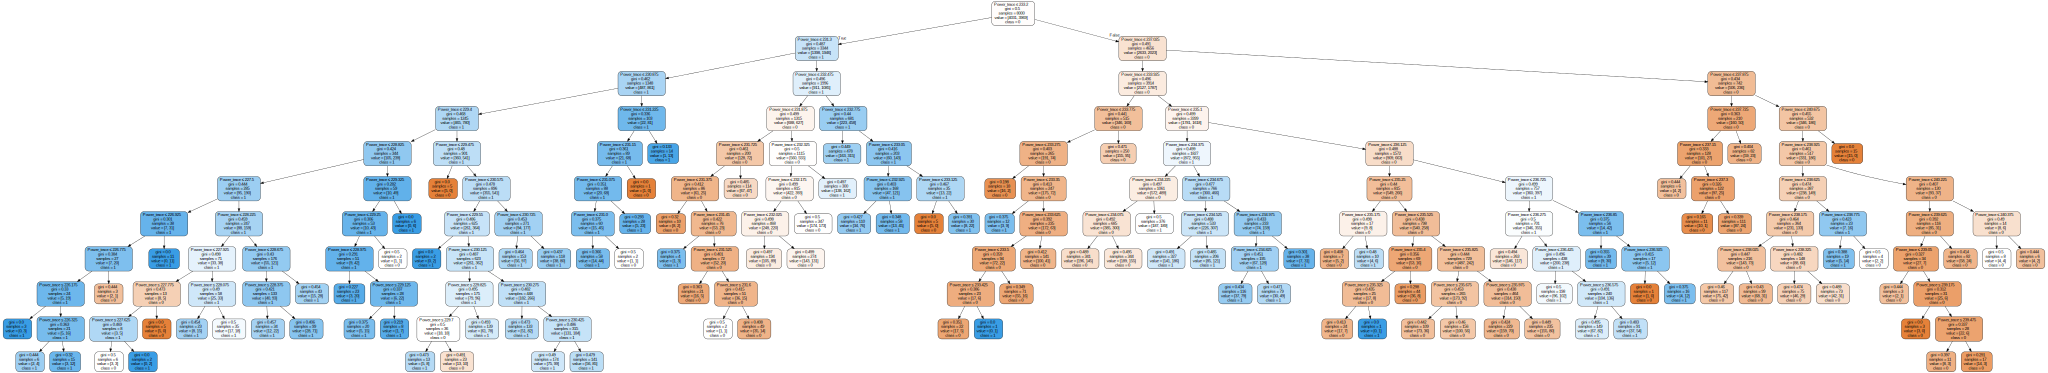

In [21]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, feature_names=df.columns[:-1], class_names=['0','1'],
                           filled=True, rounded=True, special_characters=True)
# Draw tree
graph = graphviz.Source(dot_data)
graph.render('Docs/DTree_total_power', format='png', cleanup=True)
graph